In [559]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [560]:
import zipfile
with zipfile.ZipFile('./Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [561]:
#Loading Main Data
data = pd.read_csv('data_labels_mainData.csv')
print(data.head())

   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0


In [562]:
#Checking for Nulls
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


**There are no null values in the data**

## EDA

In [15]:
#Check frequency of Categorical features to ensure that there are no errors 
frequency_name = data.groupby('cellTypeName').apply(len)
frequency_int = data.groupby('cellType').apply(len)

print(frequency_name)
print("----")
print(frequency_int)

cellTypeName
epithelial      4079
fibroblast      1888
inflammatory    2543
others          1386
dtype: int64
----
cellType
0    1888
1    2543
2    4079
3    1386
dtype: int64


We can observe that there are no error values in both categorical features and the distribution is equal among both features

isCancerous
0    5817
1    4079
Name: count, dtype: int64


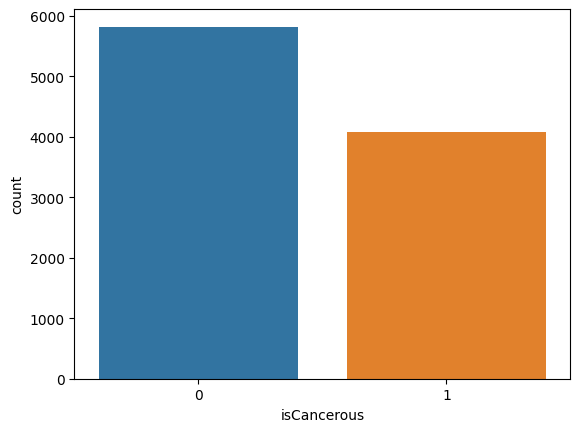

In [16]:
print(data['isCancerous'].value_counts())
sns.countplot(x='isCancerous', data=data)
plt.show()

**We have more instances of non-cancerous images**
**Further exploration is required to confirm any correlations**

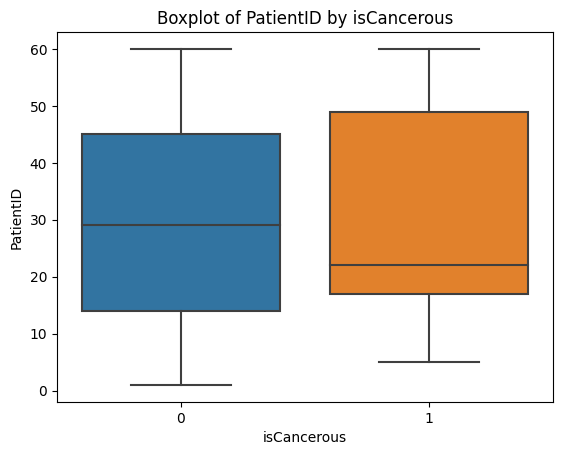

In [17]:
# Boxplots to observe relationship between PatientId and isCancerous
sns.boxplot(x='isCancerous', y='patientID', data=data)
plt.title('Boxplot of PatientID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('PatientID')
plt.show()

**No apparent correlation can be found**

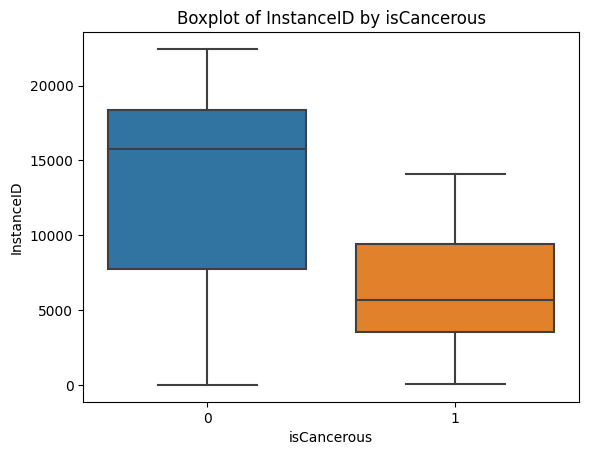

In [18]:
# Plot boxplots of numeric variables
sns.boxplot(x='isCancerous', y='InstanceID', data=data)
plt.title('Boxplot of InstanceID by isCancerous')
plt.xlabel('isCancerous')
plt.ylabel('InstanceID')
plt.show()

**We can see that the initial instanceIDs had much more occurances of cancerous cells rather than the later instances**

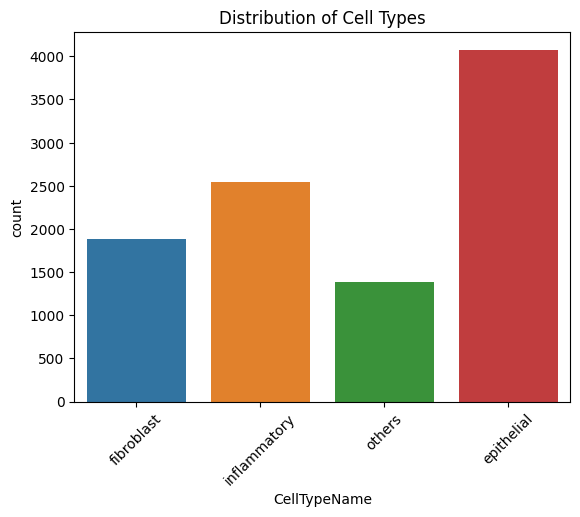

In [19]:
# Check distribution of cell types
sns.countplot(x='cellTypeName', data=data)
plt.title('Distribution of Cell Types')
plt.xlabel('CellTypeName')
plt.xticks(rotation=45)
plt.show()

**We have a notably higher number of epithelial cells as compared to other types of cells**

ValueError: could not convert string to float: '22405.png'

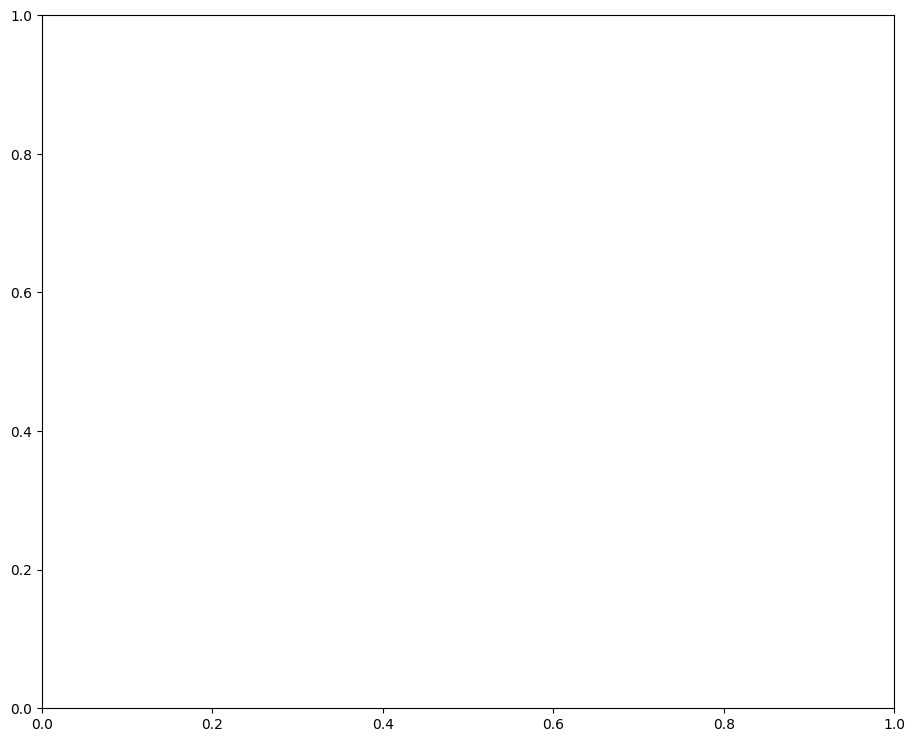

In [20]:
f, ax = plt.subplots(figsize=(11, 9))
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True
)

**Observations**
- As observed with boxplots, a correlation exists between the instance and isCancerous target value
- There is also a correlation between the two target variables: cellType and isCancerous. This can be explored further

In [21]:
from PIL import Image

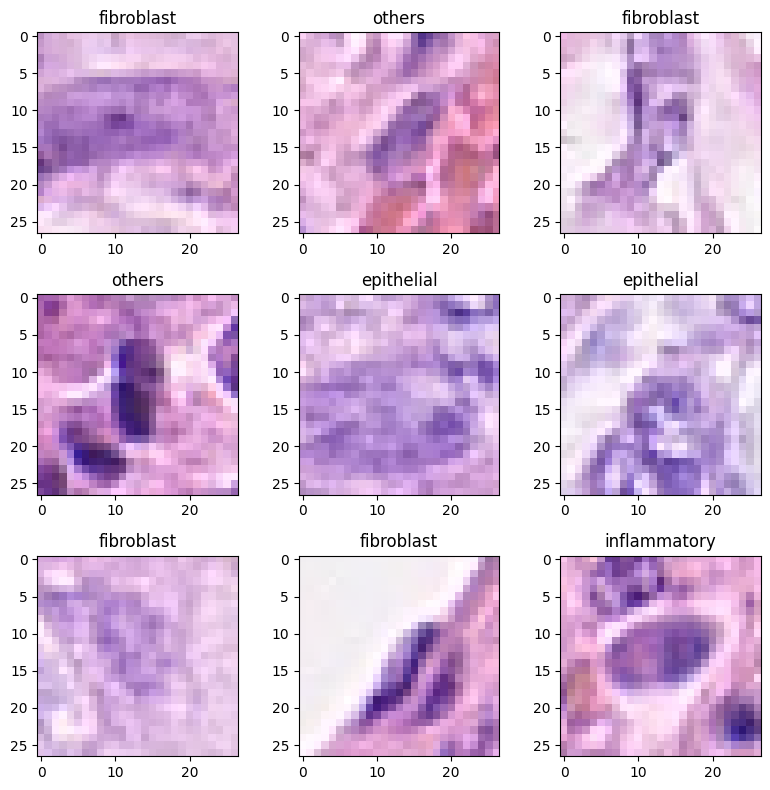

In [22]:
# Display sample images
sample_images = data['ImageName'].sample(9)
plt.figure(figsize=(8,8))
for i, img_name in enumerate(sample_images):
    plt.subplot(3,3,i+1)
    img = Image.open('patch_images/' + img_name)
    plt.imshow(img)
    plt.title(data[data['ImageName']==img_name]['cellTypeName'].values[0])
plt.tight_layout()
plt.show()

**Observations**
- While these are random samples, we can see a specific pattern of round purple objects in epithelical cells

In [23]:
# Check for image dimensions
img_dims = []
for img_name in data['ImageName']:
    img = Image.open('patch_images/' + img_name)
    img_dims.append(img.size)
img_dims = np.array(img_dims)
print('Image Dimensions:')
print('Min:', np.min(img_dims, axis=0))
print('Max:', np.max(img_dims, axis=0))
print('Mean:', np.mean(img_dims, axis=0))

Image Dimensions:
Min: [27 27]
Max: [27 27]
Mean: [27. 27.]


The images have a consistent size of 27x27 pixels

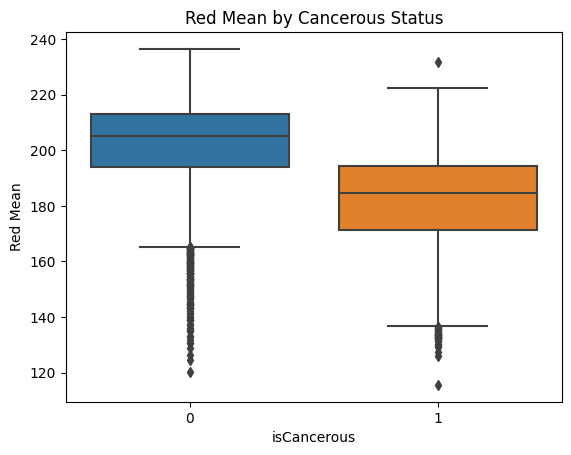

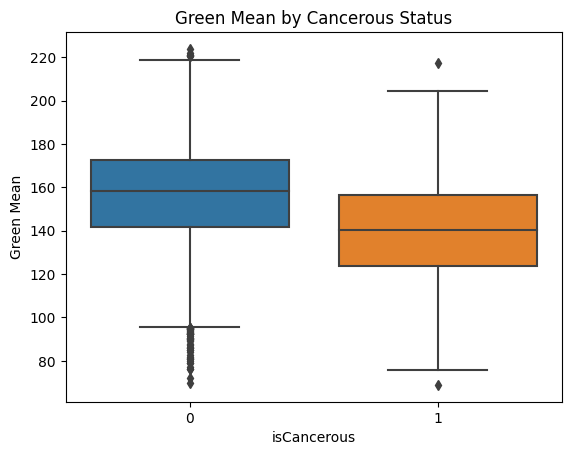

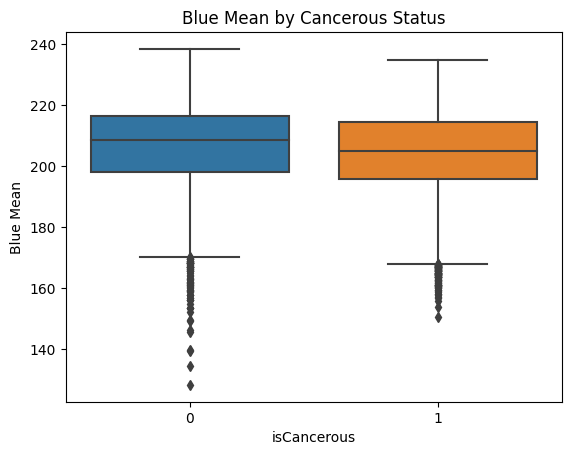

In [24]:
# Check for color distribution
colors = ['Red', 'Green', 'Blue']
for color in colors:
    color_values = []
    for img_name in data['ImageName']:
        img = Image.open('patch_images/' + img_name)
        color_values.append(np.mean(np.array(img)[:,:,colors.index(color)]))
    data[color + ' Mean'] = color_values
sns.boxplot(x='isCancerous', y='Red Mean', data=data)
plt.title('Red Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Green Mean', data=data)
plt.title('Green Mean by Cancerous Status')
plt.show()
sns.boxplot(x='isCancerous', y='Blue Mean', data=data)
plt.title('Blue Mean by Cancerous Status')
plt.show()

**Observations**
- Non Cancerous cells have higher values of the color red
- Non Cancerous cells have higher values of the color Green
- Color of Blue is mostly evenly distributed among Cancerous and non cancerous images

In [25]:
# Check for edge cases
edge_cases = []
for img_name in data['ImageName']:
    img = Image.open('patch_images/' + img_name)
    if np.max(np.array(img)) > 255:
        edge_cases.append(img_name)
print('Number of edge cases:', len(edge_cases))

if(len(edge_cases)>=1):
    print('Example edge case:', edge_cases[0])
    img = Image.open('Image_classification_data/patch_images/' + edge_cases[0])
    plt.imshow(img)
    plt.title('Example Edge Case')
    plt.show()

Number of edge cases: 0


# Constructing a Baseline Model

In [769]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0],test_data.shape[0]))

Train data : 5937, Val data: 1979, Test Data: 1980


In [780]:
# train_data['cellTypeName'] = train_data['cellTypeName'].astype('str')
# val_data['cellTypeName'] = val_data['cellTypeName'].astype('str')

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellTypeName",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellTypeName",
        target_size=(32, 32),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [781]:
import matplotlib.pyplot as plt
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [785]:
import tensorflow as tf
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(32, activation='relu', kernel_initializer='he_uniform', input_shape=(32, 32, 3)))
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Flatten())
model.add(Dense(4, activation='relu'))

In [786]:
model.compile(optimizer=SGD(),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['categorical_accuracy'])

In [787]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=25,
    validation_data=validation_generator,
    validation_steps=len(validation_generator))

Epoch 1/25
186/186 [==============================] - 11s 48ms/step - loss: 10.1318 - categorical_accuracy: 0.1366 - val_loss: 10.0844 - val_categorical_accuracy: 0.1410
Epoch 2/25
186/186 [==============================] - 4s 21ms/step - loss: 10.1172 - categorical_accuracy: 0.1356 - val_loss: 10.0574 - val_categorical_accuracy: 0.1410
Epoch 3/25
186/186 [==============================] - 4s 20ms/step - loss: 10.0949 - categorical_accuracy: 0.1356 - val_loss: 10.0398 - val_categorical_accuracy: 0.1410
Epoch 4/25
186/186 [==============================] - 4s 21ms/step - loss: 10.0795 - categorical_accuracy: 0.1356 - val_loss: 10.0271 - val_categorical_accuracy: 0.1410
Epoch 5/25
186/186 [==============================] - 4s 21ms/step - loss: 10.0680 - categorical_accuracy: 0.1356 - val_loss: 10.0174 - val_categorical_accuracy: 0.1410
Epoch 6/25
186/186 [==============================] - 4s 20ms/step - loss: 10.0590 - categorical_accuracy: 0.1356 - val_loss: 10.0097 - val_categorical_ac

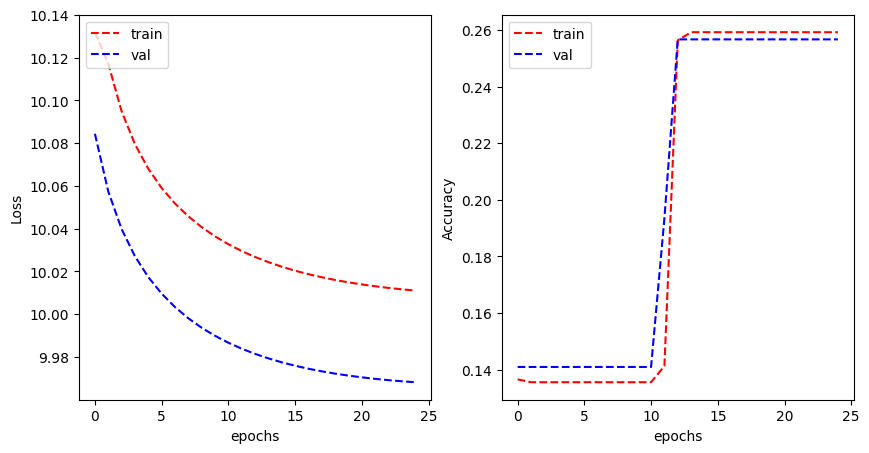

In [788]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [827]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

OUTPUT_CLASSES = 4

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0],test_data.shape[0]))

Train data : 5937, Val data: 1979, Test Data: 1980


In [828]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=45, width_shift_range=0.23,
                                   height_shift_range=0.23)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.


In [829]:
import tensorflow as tf
from keras.optimizers import SGD
from keras import regularizers
from tensorflow.keras import layers

model = tf.keras.Sequential()
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))

# Output layer
model.add(layers.Dense(OUTPUT_CLASSES, activation='softmax'))


In [830]:
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.optimizers import SGD

class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(data['cellType']),
                                        y = data['cellType']                                                    
                                    )
class_weights = dict(zip(np.unique(data['cellType']), class_weights))

loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

model.compile(optimizer=Adam(),
              loss=loss,
              metrics=['categorical_accuracy', 'mse'])


learn_control = ReduceLROnPlateau(monitor='val_categorical_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-20)

filepath="weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_categorical_accuracy', verbose=1, save_best_only=True, mode='max')

In [831]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    class_weight=class_weights,
    shuffle=True,
    callbacks=[learn_control, checkpoint])

Epoch 1/60
186/186 [==============================] - ETA: 0s - loss: 1.2713 - categorical_accuracy: 0.4512 - mse: 0.1634
Epoch 1: val_categorical_accuracy improved from -inf to 0.41536, saving model to weights.best.hdf5
186/186 [==============================] - 23s 108ms/step - loss: 1.2713 - categorical_accuracy: 0.4512 - mse: 0.1634 - val_loss: 1.2058 - val_categorical_accuracy: 0.4154 - val_mse: 0.1639 - lr: 0.0010
Epoch 2/60
185/186 [============================>.] - ETA: 0s - loss: 1.0407 - categorical_accuracy: 0.5113 - mse: 0.1402
Epoch 2: val_categorical_accuracy improved from 0.41536 to 0.50935, saving model to weights.best.hdf5
186/186 [==============================] - 12s 62ms/step - loss: 1.0410 - categorical_accuracy: 0.5115 - mse: 0.1401 - val_loss: 1.0000 - val_categorical_accuracy: 0.5093 - val_mse: 0.1328 - lr: 0.0010
Epoch 3/60
185/186 [============================>.] - ETA: 0s - loss: 0.9807 - categorical_accuracy: 0.5715 - mse: 0.1287
Epoch 3: val_categorical_acc

185/186 [============================>.] - ETA: 0s - loss: 0.6701 - categorical_accuracy: 0.7463 - mse: 0.0875
Epoch 21: val_categorical_accuracy did not improve from 0.79080
186/186 [==============================] - 11s 60ms/step - loss: 0.6699 - categorical_accuracy: 0.7472 - mse: 0.0873 - val_loss: 0.6327 - val_categorical_accuracy: 0.7458 - val_mse: 0.0858 - lr: 0.0010
Epoch 22/60
185/186 [============================>.] - ETA: 0s - loss: 0.6888 - categorical_accuracy: 0.7385 - mse: 0.0906
Epoch 22: val_categorical_accuracy did not improve from 0.79080
186/186 [==============================] - 11s 61ms/step - loss: 0.6886 - categorical_accuracy: 0.7388 - mse: 0.0905 - val_loss: 0.6259 - val_categorical_accuracy: 0.7620 - val_mse: 0.0843 - lr: 0.0010
Epoch 23/60
185/186 [============================>.] - ETA: 0s - loss: 0.6717 - categorical_accuracy: 0.7421 - mse: 0.0876
Epoch 23: val_categorical_accuracy did not improve from 0.79080
186/186 [==============================] - 11s 

186/186 [==============================] - ETA: 0s - loss: 0.5204 - categorical_accuracy: 0.8092 - mse: 0.0681
Epoch 41: val_categorical_accuracy did not improve from 0.81405
186/186 [==============================] - 11s 60ms/step - loss: 0.5204 - categorical_accuracy: 0.8092 - mse: 0.0681 - val_loss: 0.5333 - val_categorical_accuracy: 0.7974 - val_mse: 0.0721 - lr: 2.0000e-04
Epoch 42/60
185/186 [============================>.] - ETA: 0s - loss: 0.5140 - categorical_accuracy: 0.8061 - mse: 0.0681
Epoch 42: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 42: val_categorical_accuracy did not improve from 0.81405
186/186 [==============================] - 11s 60ms/step - loss: 0.5135 - categorical_accuracy: 0.8060 - mse: 0.0681 - val_loss: 0.5233 - val_categorical_accuracy: 0.8019 - val_mse: 0.0705 - lr: 2.0000e-04
Epoch 43/60
186/186 [==============================] - ETA: 0s - loss: 0.4888 - categorical_accuracy: 0.8157 - mse: 0.0652
Epoch 43: val_categorica

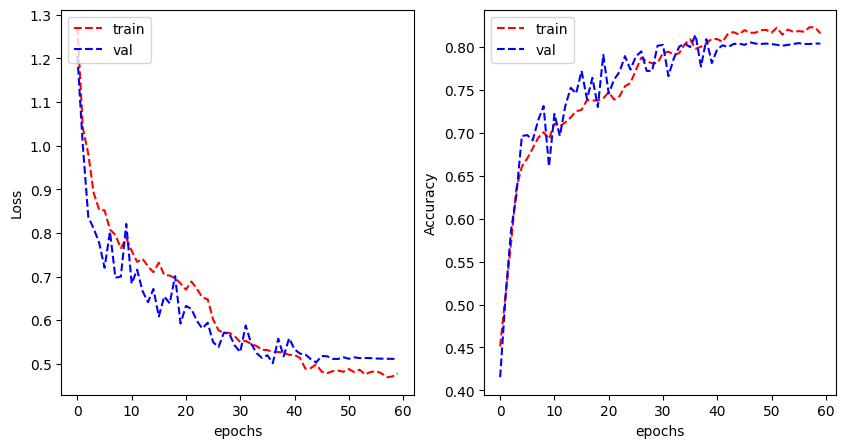

In [833]:
plot_learning_curve(history.history['loss'], history.history['val_loss'], 
                    history.history['categorical_accuracy'], history.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [836]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1


test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='categorical')

model.load_weights(checkpoint.filepath, by_name=True)

Found 1980 validated image filenames belonging to 4 classes.


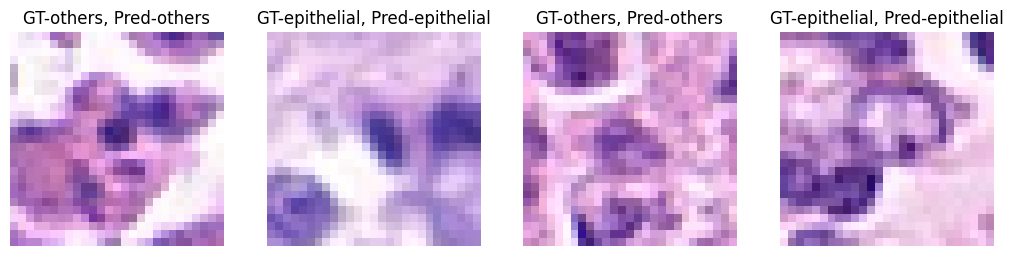

In [837]:
d_inv = {v: k for k, v in d.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("GT-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

In [838]:
print("Evaluate model on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_generator)
print("prediction shape:", prediction.shape)

Evaluate model on test data
1980/1980 [==============================] - 69s 34ms/step - loss: 0.5673 - categorical_accuracy: 0.7859 - mse: 0.0759
test loss, test acc: [0.5673491954803467, 0.7858586311340332, 0.07588352262973785]
Generate a prediction
1980/1980 [==============================] - 8s 3ms/step
prediction shape: (1980, 4)


In [875]:
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd

train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0],test_data.shape[0]))

Train data : 5937, Val data: 1979, Test Data: 1980


In [876]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')

In [877]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', rotation_range=45, width_shift_range=0.25,
                                   height_shift_range=0.25)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col= "isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col= "isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='binary')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.


In [883]:
model = tf.keras.Sequential()
# Convolutional layers
model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(27, 27, 3)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(layers.MaxPooling2D((2, 2)))
          
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_uniform',))
model.add(MaxPooling2D((2, 2)))

# Flatten layer
model.add(layers.Flatten())

# Dense layers
model.add(layers.Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dropout(rate=0.5))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))


In [884]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-20)

filepath="weights_binary.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [885]:
history_binary = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=40,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    shuffle=True,
    callbacks=[learn_control, checkpoint])

Epoch 1/40
186/186 [==============================] - ETA: 0s - loss: 0.6625 - accuracy: 0.6096
Epoch 1: val_accuracy improved from -inf to 0.84841, saving model to weights_binary.best.hdf5
186/186 [==============================] - 16s 68ms/step - loss: 0.6625 - accuracy: 0.6096 - val_loss: 0.4928 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 2/40
183/186 [============================>.] - ETA: 0s - loss: 0.4288 - accuracy: 0.8175
Epoch 2: val_accuracy improved from 0.84841 to 0.87468, saving model to weights_binary.best.hdf5
186/186 [==============================] - 4s 23ms/step - loss: 0.4289 - accuracy: 0.8179 - val_loss: 0.3348 - val_accuracy: 0.8747 - lr: 0.0010
Epoch 3/40
184/186 [============================>.] - ETA: 0s - loss: 0.3451 - accuracy: 0.8542
Epoch 3: val_accuracy did not improve from 0.87468
186/186 [==============================] - 4s 22ms/step - loss: 0.3439 - accuracy: 0.8545 - val_loss: 0.3036 - val_accuracy: 0.8570 - lr: 0.0010
Epoch 4/40
185/186 [==============

186/186 [==============================] - 4s 19ms/step - loss: 0.2060 - accuracy: 0.9210 - val_loss: 0.1890 - val_accuracy: 0.9222 - lr: 2.0000e-04
Epoch 28/40
184/186 [============================>.] - ETA: 0s - loss: 0.2007 - accuracy: 0.9203
Epoch 28: val_accuracy did not improve from 0.92370
186/186 [==============================] - 4s 19ms/step - loss: 0.2008 - accuracy: 0.9205 - val_loss: 0.1919 - val_accuracy: 0.9232 - lr: 2.0000e-04
Epoch 29/40
186/186 [==============================] - ETA: 0s - loss: 0.1996 - accuracy: 0.9208
Epoch 29: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.

Epoch 29: val_accuracy did not improve from 0.92370
186/186 [==============================] - 4s 19ms/step - loss: 0.1996 - accuracy: 0.9208 - val_loss: 0.1895 - val_accuracy: 0.9237 - lr: 2.0000e-04
Epoch 30/40
185/186 [============================>.] - ETA: 0s - loss: 0.1972 - accuracy: 0.9238
Epoch 30: val_accuracy did not improve from 0.92370
186/186 [==================

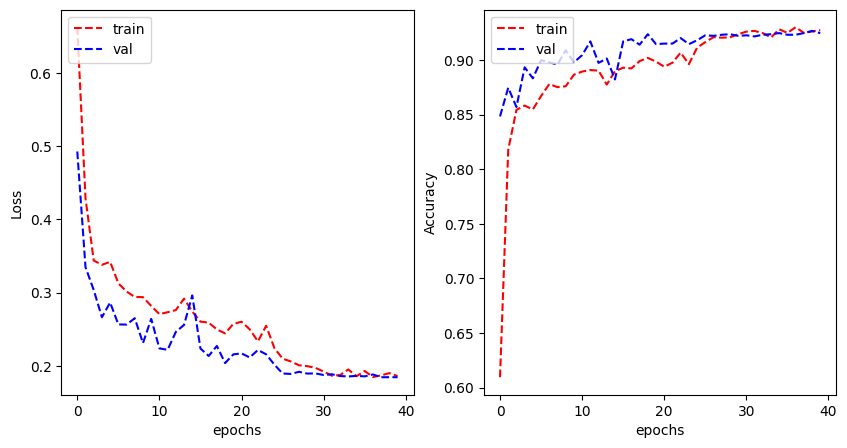

In [886]:
plot_learning_curve(history_binary.history['loss'], history_binary.history['val_loss'], 
                    history_binary.history['accuracy'], history_binary.history['val_accuracy'], 
                    metric_name='Accuracy')

In [887]:
test_data['isCancerous'] = test_data['isCancerous'].astype('str')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size_t = 1


test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images',
        x_col= "ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size_t,
        class_mode='binary')

model.load_weights(checkpoint.filepath, by_name=True)

Found 1980 validated image filenames belonging to 2 classes.


In [888]:
print("Evaluate model on test data")
results = model.evaluate(test_generator)
print("test loss, test acc:", results)

# Generate a prediction using model.predict() 
# and calculate it's shape:
print("Generate a prediction")
prediction = model.predict(test_generator)
print("prediction shape:", prediction.shape)

Evaluate model on test data
1980/1980 [==============================] - 12s 6ms/step - loss: 0.1992 - accuracy: 0.9237
test loss, test acc: [0.19924296438694, 0.9237374067306519]
Generate a prediction
1980/1980 [==============================] - 8s 3ms/step
prediction shape: (1980, 1)
